
![](radii.png)

In [1]:
from coagulation_model.coagulation_kernel import coagulation_kernel as kernel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
from coagulation_model.coagulation_kernel import coagulation_kernel as kernel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# create empty matrix to store beta values
def plot_kernel(kernel, kernel_name, n=100, r_min=1e-6, r_max=1e-3,norm_range=[1e-15, 1e-8]):
    beta = np.zeros((n,n))

    r_i = np.linspace(r_min, r_max, n)
    r_j = np.linspace(r_min, r_max, n)

    # calculate beta values
    for i in range(n):
        for j in range(n):
            beta[i,j] = kernel.evaluate_kernel(r_i[i], r_j[j])
    print(np.min(beta), np.max(beta))

    fig, ax = plt.subplots()

    norm = LogNorm(vmin=norm_range[0], vmax=norm_range[1])

    # imshow with log scale with a norm range
    ax.imshow(beta, extent=np.array([r_min, r_max, r_min, r_max])*1e3, norm=norm, origin='lower')

    # colorbar 
    cbar = plt.colorbar(ax.imshow(beta, extent=np.array([r_min, r_max, r_min, r_max])*1e3, norm=norm, origin='lower'))
    # add colobar label
    cbar.set_label('Beta (mm^3/s)')

    

    # add labels
    ax.set_xlabel('Radius of particle i (mm)')
    ax.set_ylabel('Radius of particle j (mm)')

    # add title
    fig.suptitle(kernel_name)

    return fig, ax

In [3]:
shear_fractal_kernel = kernel(list_of_applied_kernels=['rectilinear_shear'], settling_function='jackson_lochmann_fractal_settling_velocity')
differential_sinking_fractal_kernel = kernel(list_of_applied_kernels=['rectilinear_differential_sedimentation'], settling_function='jackson_lochmann_fractal_settling_velocity')
shear_and_differential_sinking_fractal_kernel = kernel(list_of_applied_kernels=['rectilinear_shear', 'rectilinear_differential_sedimentation'], settling_function='jackson_lochmann_fractal_settling_velocity')

2.6160742400000014e-14 2.6160742400000018e-11


0.0 5.0806953190400746e-08
2.6160742400000014e-14 5.0817989753600745e-08


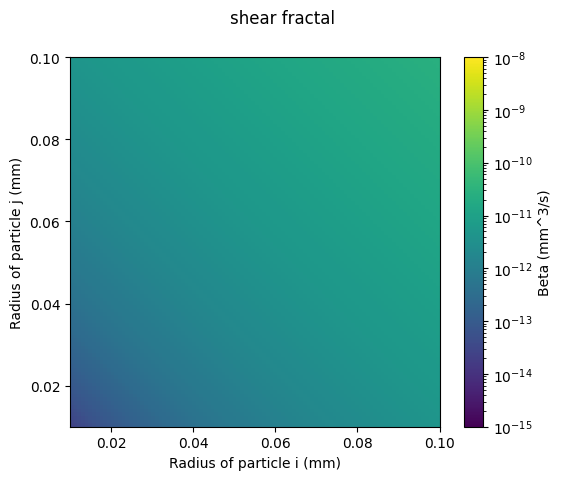

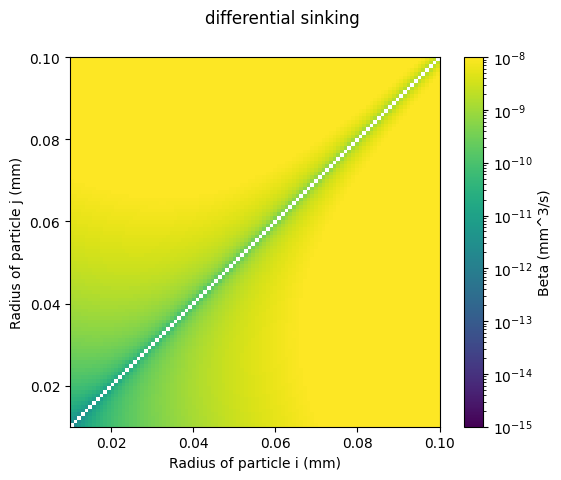

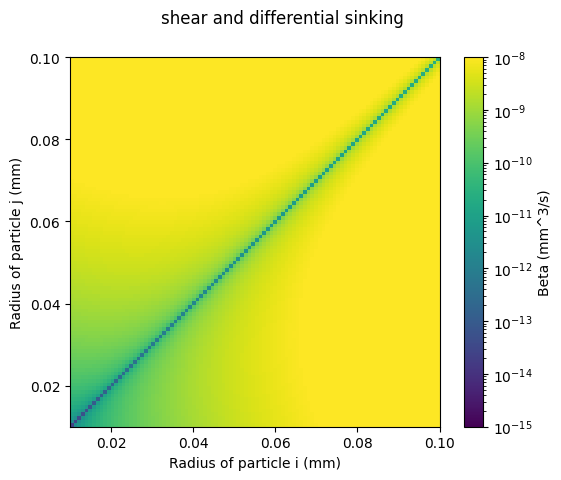

In [4]:
# calculate beta kernels for a range of particle sizes 
r_min = 1e-5
r_max = 1e-4
n = 100

fig,ax = plot_kernel(shear_fractal_kernel, 'shear fractal', n, r_min, r_max)
# save fig
fig.savefig('shear_fractal_kernel.png')

fig,ax = plot_kernel(differential_sinking_fractal_kernel, 'differential sinking', n, r_min, r_max)
# save fig
fig.savefig('differential_sinking_fractal_kernel.png')

fig,ax = plot_kernel(shear_and_differential_sinking_fractal_kernel, 'shear and differential sinking', n, r_min, r_max)
# save fig
fig.savefig('shear_and_differential_sinking_fractal_kernel.png')



## debug

### playing with radius definitions

In [5]:
# radius of sphere with mass density 2650 kg/m^3 and mass 1e-4 kg
density = 2650
mass = 1e-6

r = (3*mass/(4*np.pi*density))**(1/3)
print(f'radius of sphere with mass {mass} kg and density {density} kg/m^3 is {round(r*1e6, 2)} um')

radius of sphere with mass 1e-06 kg and density 2650 kg/m^3 is 448.29 um


In [7]:
radius_of_conserved_volume = shear_fractal_kernel.radius_conserved_volume(mass)
radius_of_fractal = shear_fractal_kernel.radius_fractal(mass)
radius_of_gyration = shear_fractal_kernel.radius_gyration(mass)

# scatter plot of radius of conserved volume, radius of fractal and radius of gyration
fig, ax = plt.subplots()
ax.scatter(mass, radius_of_conserved_volume, label='radius of conserved volume')
ax.scatter(mass, radius_of_fractal, label='radius of fractal')
ax.scatter(mass, radius_of_gyration, label='radius of gyration')
ax.set_xlabel('mass (kg)')
ax.set_ylabel('radius (m)')

ax.set_ylim([0, np.max([radius_of_conserved_volume, radius_of_fractal, radius_of_gyration])*1.1])
ax.legend()


AttributeError: 'coagulation_kernel' object has no attribute 'radius_of_conserved_volume'

0.0320442450666159

### looking at falling velocities 

In [6]:
def SetUpCoag():
    """
    Set up coagulation calculations with default parameters and options.

    Returns:
        param: Dictionary of physical and calculation parameters.
        opt: Dictionary of runtime options.
    """
    param = {
        'rho_fl': 1.0275,  # Fluid density [g cm^{-3}]
        'kvisc': 0.01,  # Kinematic viscosity [cm^2 s^{-1}]
        'g': 980,  # Accel. due to gravity [cm s^{-2}]
        'day_to_sec': 8.64e04,  # Seconds in a day [s d^{-1}]
        'k': 1.3e-16,  # Boltzmann's constant [erg K^{-1}]
        'r_to_rg': 1.36,  # Interaction radius to radius of gyration
        'n_sections': 20,  # Number of sections
        'kernel': 'KernelBrown',  # Kernel type
        'd0': 20e-4,  # Diameter of unit particle [cm]
        'fr_dim': 2.33,  # Particle fractal dimension
        'n1': 100,  # No. particles cm^{-3} in first section
        'temp': 20 + 273,  # Temperature [K]
        'alpha': 1.0,  # Stickiness
        'dz': 65,  # Layer thickness [m]
        'gamma': 0.1,  # Average shear rate [s^{-1}]
        'growth': 0.15,  # Specific growth rate in first section [d^{-1}]
        'gro_sec': 4,  # Section at which growth in aggregates starts
        'num_1': 10**3,  # Number of particle cm^{-3} in first section
        'c3': 0.2,  # Disaggregation parameter
        'c4': 1.45,  # Disaggregation parameter
        't_init': 0.0,  # Initial time for integrations [d]
        't_final': 30.0,  # Final time for integrations [d]
        'delta_t': 1.0,  # Time interval for output [d]
    }

    # Derived parameters
    param['dvisc'] = param['kvisc'] * param['rho_fl']  # Dynamic viscosity [g cm^{-1} s^{-1}]
    param['del_rho'] = (4.5 * 2.48) * param['kvisc'] * param['rho_fl'] / param['g'] * (param['d0'] / 2) ** (-0.83)
    param['conBr'] = 2.0 / 3.0 * param['k'] * param['temp'] / param['dvisc']
    param['a0'] = param['d0'] / 2
    param['v0'] = (np.pi / 6) * param['d0'] ** 3
    param['v_lower'] = param['v0'] * 2. ** np.arange(param['n_sections'])
    param['v_upper'] = 2.0 * param['v_lower']
    param['av_vol'] = 1.5 * param['v_lower']
    param['dcomb'] = (param['v_lower'] * 6 / np.pi) ** (1.0 / 3.0)
    param['dwidth'] = (2 ** (1.0 / 3.0) - 1) * param['dcomb']
    amfrac = (4.0 / 3.0 * np.pi) ** (-1.0 / param['fr_dim']) * param['a0'] ** (1.0 - 3.0 / param['fr_dim'])
    param['amfrac'] = amfrac * np.sqrt(0.6)
    param['bmfrac'] = 1. / param['fr_dim']
    param['setcon'] = (2.0 / 9.0) * param['del_rho'] / param['rho_fl'] * param['g'] / param['kvisc']


    return param


param = SetUpCoag()


In [7]:
def SettlingVelocity(r, rcons, sett_const):
    """
    Calculate the settling velocities of particles of given sizes.

    Parameters:
    - r: Numpy array of particle radii [cm]
    - rcons: Numpy array of radii of particle conserved volumes [cm]
    - sett_const: Constant for settling velocity calculation, 
                  defined as (2g/9eta)*(delta_rho/rho_fluid)

    Returns:
    - v: Numpy array of particle settling velocities [cm s^{-1}]
    """
    v = sett_const * rcons**3 / r
    return v

In [32]:
particle_radii_in_m = 1e-3
particle_radii_in_cm = particle_radii_in_m * 100

unit_radii_in_m = 20e-6/2
unit_radii_in_cm = unit_radii_in_m * 100

settling_constant_in_cm = 2.48 * (unit_radii_in_cm)**(-0.83)

settling_cm = SettlingVelocity(particle_radii_in_cm, particle_radii_in_cm, settling_constant_in_cm)
settling_m = SettlingVelocity(particle_radii_in_m, particle_radii_in_m, settling_constant_in_cm*100)


print('cm based')
print('-----------------')
print(f'UnitRadius \t\t{round(unit_radii_in_cm,5)}cm')
print(f'Radius \t\t\t{round(particle_radii_in_cm,5)}cm')
print(f'SettlingVelocity \t{round(settling_cm,5)}cm/s')


print('m based')
print('-----------------')
print(f'UnitRadius \t\t{round(unit_radii_in_m*100,5)}cm')
print(f'Radius \t\t\t{round(particle_radii_in_m*100,5)}cm')
print(f'SettlingVelocity \t{round(settling_m*100,5)}cm/s')


cm based
-----------------
UnitRadius 		0.001cm
Radius 			0.1cm
SettlingVelocity 	7.66393cm/s
m based
-----------------
UnitRadius 		0.001cm
Radius 			0.1cm
SettlingVelocity 	7.66393cm/s


### figuring out rcons

In [2]:
diameter_initial = 1
radius_initial = diameter_initial / 2
volume_initial = (4/3) * np.pi * radius_initial**3

radius_backtransformed = (0.75/np.pi*volume_initial)**(1/3)

print(radius_initial)
print(radius_backtransformed)

0.5
0.5


In [3]:
shear_fractal_kernel = kernel(list_of_applied_kernels=['rectilinear_shear'], settling_function='jackson_lochmann_fractal_settling_velocity')

radius_of_conserved_volume = shear_fractal_kernel.radius_conserved_volume(volume_initial)
radius_of_fractal = shear_fractal_kernel.radius_fractal(volume_initial)
radius_of_gyration = shear_fractal_kernel.radius_gyration(volume_initial)

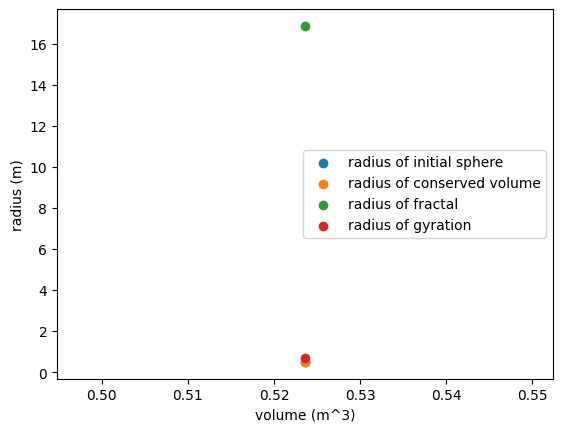

In [4]:
# plot all four radii in a scatter plot
fig, ax = plt.subplots()
ax.scatter(volume_initial, radius_initial, label='radius of initial sphere')
ax.scatter(volume_initial, radius_of_conserved_volume, label='radius of conserved volume')
ax.scatter(volume_initial, radius_of_fractal, label='radius of fractal')
ax.scatter(volume_initial, radius_of_gyration, label='radius of gyration')
ax.set_xlabel('volume (m^3)')
ax.set_ylabel('radius (m)')

#label
ax.legend()


5e-06
5.000000000000004e-06
1e-05
1.0000000000000006e-05
1.5000000000000002e-05
1.500000000000001e-05
2e-05
2.0000000000000012e-05
2.5e-05
2.5000000000000015e-05
3e-05
3.0000000000000018e-05
3.5000000000000004e-05
3.5000000000000024e-05
4e-05
4.0000000000000024e-05
4.5e-05
4.500000000000003e-05
5e-05
5.000000000000003e-05


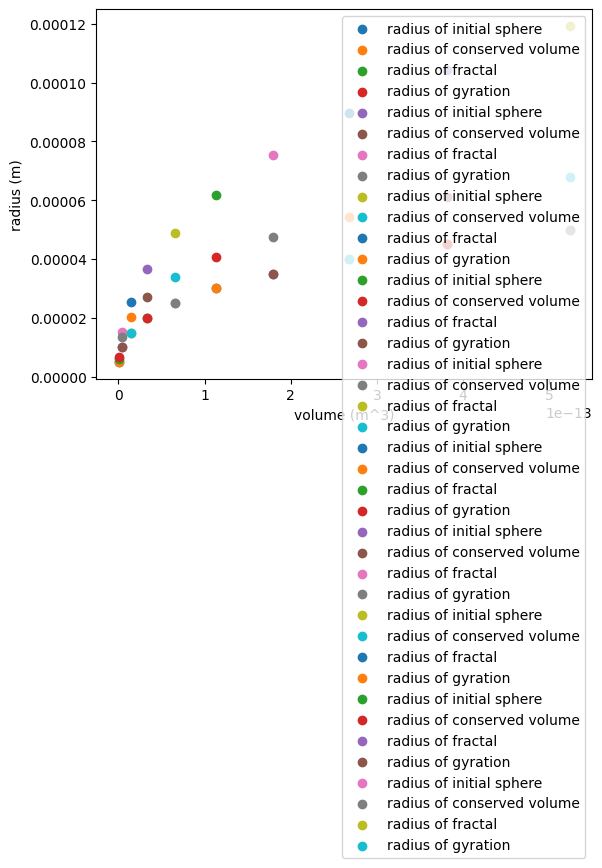

In [6]:


def new_func(ax, diameter_initial):
    radius_initial = diameter_initial / 2
    volume_initial = (4/3) * np.pi * radius_initial**3

    radius_backtransformed = (0.75/np.pi*volume_initial)**(1/3)

    print(radius_initial)
    print(radius_backtransformed)

    shear_fractal_kernel = kernel(list_of_applied_kernels=['rectilinear_shear'], settling_function='jackson_lochmann_fractal_settling_velocity')

    radius_of_conserved_volume = shear_fractal_kernel.radius_conserved_volume(volume_initial)
    radius_of_fractal = shear_fractal_kernel.radius_fractal(volume_initial)
    radius_of_gyration = shear_fractal_kernel.radius_gyration(volume_initial)

    ax.scatter(volume_initial, radius_initial, label='radius of initial sphere')
    ax.scatter(volume_initial, radius_of_conserved_volume, label='radius of conserved volume')
    ax.scatter(volume_initial, radius_of_fractal, label='radius of fractal')
    ax.scatter(volume_initial, radius_of_gyration, label='radius of gyration')
    ax.set_xlabel('volume (m^3)')
    ax.set_ylabel('radius (m)')

#label
    ax.legend()

fig, ax = plt.subplots()
for ii in np.linspace(1e-5,1e-4,10):
    new_func(ax, ii)
